# Introduction

In this notebook, we will implement word embeddings for job postings using [Word2vec](https://en.wikipedia.org/wiki/Word2vec). By implementing this, you will learn about embedding words in job postings such as job titles and skills. This will be useful when for sementic job search, for instance.

Table of contents

- [Word embeddings, word2vec](#Word-embeddings,-word2vec)
- [Job posting data](#Job-posting-data)
- [Data preprocessing](#Data-preprocessing)
- [Training](#Training)
- [Visualization](#Visualization)
- [Future work](#Future-work)
- [Reading](#Reading)

# Word embeddings, word2vec
Word2vec is a machine learning model used for learning vector representation of words, called "word embeddings".
Before starting implemenation, let's look at why we would want to learn word embeddings in the first place.

## Why learn word embeddings?
Natural language processing (NLP) traditonally convert words to discrete symboles or ids.  
e.g. `I like cats and dogs.` -> `[23, 761, 748, 221, 309] `

These encondings provide no useful information about relationships that may exist between individual symbols. Furthermore, representing words as unique, discrete ids leads to data sparsity, and requires many data.  
Using vector representations can overcome some of these issues.

## Word2vec
Word2vec is a neural network model which allows you to vectorize words.
If you are interested in how to calculate vectors of words, read some of readings listed below.

### Architectures
There are 2 architectures for implementing word2vec, **CBOW** (Continuous Bag-Of-Words) and **Skip-gram**.  

**CBOW** is learning to predict the word by the context, on the other hand, the **Skip-gram** is designed to predict the context.
For example, if the sentence is "*The cat ate the mouse*"  and the current word is `ate`,   
In **CBOW**, `['The', 'cat', 'the', 'mouse']` will be calculating `ate`, while `ate` will be caluclating `['The', 'cat', 'the', 'mouse']` in **Skip-gram**.

<img src="assets/word2vec_diagrams.png" width="700">

You don't need to understand these architectures completely, the important point is that word2vec model learns mearning of words from contexts.

### Similarity
Each word will be located as a point in hundreds-dimentional vectorspace (practically 100 - 500 dimentions).  
A well trained set of word vectors will place similar words close to eh other in that space.  
For instance, `dogs` and `cats` might cluster in one corner, while `war`, `conflict` and `strife` do in another.

### Translation
Word2vec can learn many associations other than similarity.  
For instance, it can gauge relations between words of one language, and map them to another.

<img src="assets/word2vec_translation.png" width="700">

### Distance
These vectors are the basis of a more comprehensive geometry of words.  Not only will Rome, Paris, Berlin and Beijing cluster near each other, but they will each have similar distances in vectorspace to the countries whose capitals they are.

<img src="assets/countries_capitals.png" width="700">

So you can find the capital of Japan by calculating `Rome - Italy + Japan = Tokyo`.  
Another famous example would be `king - man + woman = queen`.

## How are job word embeddings useful?
One of the reasons why we would want to learn "job word embeddings" is that it will be useful when finding jobs that have simiar job titles with your current one, which is difficult to be done by traditonal search engine.  

<style>
table {margin: none;}
</style>

|Target|Similar job titles|
|:---|:---|
|Web engineer| Server side eingeer, fullstack engineer, front-end engineer|
|Infra engineer| Devops engineer, System reliability engineer|
|Data scientist| Data analyist, Data engineer, Machine learning engineer|

# Job posting data
We need job postings text data to learn word embeddings.

The prepared dataset has 12130 postings with many fields: `job_title`, `summary`, `requirements`, `salary`, `location` etc. some explain job content well, other don't. we can decide which fields to use for learning.

Let's look at the raw data.

In [1]:
import pandas as pd

job_postings = pd.read_csv('./data/job_postings.csv')
job_postings.head()

,job_title,page_title,location,salary,summary,requirements,about_company,department,job_highlight,reason_for_hiring,tags
0,人事労務,【LINE】社員がやりがいをもって働ける環境を整える、人事労務,福岡県,400万円〜,LINEおよび関連サービスの開発・クリエイティブ・運営・企画営業などあらゆる業務を行っていま...,【必須の経験・スキル】\n・人事労務業務経験3年以上\n【歓迎する経験・スキル】\n・有期雇...,ミッション「CLOSING THE DISTANCE」を軸に、人と人、様々な情報・サービスを...,NaN,【仕事の魅力】\n・900名規模のグローバルカンパニーで人事労務のキャリアを積むことができる...,NaN,#企画営業
1,BtoBテレマーケティング担当(広告関連サービス/SV候補),【LINE】LINE広告関連サービスのテレマーケティング担当(SV候補),福岡県,350万円〜,LINEおよび関連サービスの開発・クリエイティブ・運営・企画営業などあらゆる業務を行っていま...,【必須の経験・スキル】\n・勢いのある広告サービスの利用規模拡大に携わることができる\n・ワ...,ミッション「CLOSING THE DISTANCE」を軸に、人と人、様々な情報・サービスを...,NaN,【仕事の魅力】\n・勢いのある広告サービスの利用規模拡大に携わることができる\n・ワークライ...,事業拡大による増員,#企画営業
2,マーケティング・プロモーション担当(LINEゲーム),【LINE】ゲームタイトルのプロモーション企画をおこなうマーケティング担当,福岡県,350万円〜,LINEおよび関連サービスの開発・クリエイティブ・運営・企画営業などあらゆる業務を行っていま...,【必須の経験・スキル】\n・プロモーション企画の提案・実施経験\n・広告のバナー制作・配信設...,ミッション「CLOSING THE DISTANCE」を軸に、人と人、様々な情報・サービスを...,NaN,【仕事の魅力】\n・グローバルに展開しているゲームのマーケティングを経験できる\n・プラット...,事業拡大による増員,#企画営業
3,【急成長イスラエルITベンチャーと働く】カスタマーサクセス職,急成長イスラエルITベンチャーと働く、カスタマーサクセスを大募集！,東京都,300万円〜600万円,■Webマーケティング事業\n■テクノロジーソリューション事業\n\n 今回募集を...,【必須スキル】 \n・BtoBセールス実務経験 \n・実務レベルの英語力 \n・Excel/...,＜会社概要＞\n今年で12期のまだまだ若くエネルギッシュな会社です。\n「いつも心にエンタテ...,テクノロジーソリューション事業部への配属となります。,【得られるスキル】 \n・カスタマーサクセスチームの立ち上げ経験 \n・グローバルで事業をグ...,最先端ツールでWEB業界を革新中の弊社がさらなる成長を目指すため、\n一緒にカスタマーサクセ...,#グローバル化\n#イスラエル\n#一気通貫
4,【最先端ツールでWEB業界を変える】セールス職,急成長中！イスラエル・シリコンバレースタートアップと働く営業を募集中！,東京都,300万円〜600万円,■Webマーケティング事業\n■テクノロジーソリューション事業\n\n ギャプライ...,【必須スキル】 \n・複数の関係者と協業できるコミュニケーション能力 \n・BtoBセールス...,＜会社概要＞\n今年で12期のまだまだ若くエネルギッシュな会社です。\n「いつも心にエンタテ...,テクノロジーソリューション事業部への配属となります。,【得られるスキル】 \n・潜在的な事業課題を導き出す高いヒアリング力 \n・チームの仕組み化...,最先端ツールでWEB業界を革新中の弊社がさらなる成長を目指すため、\n一緒にセールスを行って...,#グローバル化\n#イスラエル\n#一気通貫


# Data preprocessing

In this project, we will use `requirements`, `summary` as they seem to be explaining job contents.  and also append `job_title` to learn what each job title means.

In [37]:
sample_job = job_postings.loc[10]

In [53]:
sample_job[['requirements', 'summary']]

requirements    ★学歴不問 \n★Web／アプリケーション領域において何らかの開発経験のある方 \n※実務経...
summary         ～営業社員の強い味方★クラウドサービス「UPWARD」～ \n○社会貢献性の高いサービスに携...
Name: 10, dtype: object

The following function extracts keywords from these fields.  
We will use only nouns because they adjective, verbs, marks don't give meaningful information for this material.

In [59]:
import MeCab
# check where neologd is in your computer, and change the path in the line below.
tagger = MeCab.Tagger("-U %m,未知語\\t -F %f[0],%f[6]\\t  -d  /usr/local/lib/mecab/dic/mecab-ipadic-neologd")

def extract_nouns(text): 
    words = []
    for row in tagger.parse(text).split('\t'):
        if row.strip() == 'EOS':
            continue
        t = row.split(',')[0]
        w = row.split(',')[1]
        if t == '名詞':
            words.append(w.strip().lower())
    return words

In [54]:
print(extract_nouns(sample_job['requirements']))

['学歴', '不問', 'web', 'アプリケーション', '領域', '開発', '経験', '方', '実務', '経験', 'プログラミング', '好き', 'アプリ開発', '好き', '方', '応募', 'java', 'javascript', 'css', 'html', '開発', '経験', '方', '優遇', '方', '歓迎', '自社', '内', '腰', '医方', 'アプリ開発', '好き', '方', 'ワーク・ライフ・バランス', '医方', '自分', '裁量', '状態', '医方', '社会貢献', '性', '高位', '仕事', '医方', 'エンドユーザー', '評価', '自分', '医方', '活', '経験', 'スキル', 'システム', 'アプリケーション', '開発', '経験', '当社', '開発', 'エンジニア', '一員', '活躍', '実務', '経験', '趣味', 'プログラミング', '遊び', 'ゲーム開発', '開発', '好き', '方', '一緒に', '有名', 'もの', 'java', 'javascript', 'css', 'html', '開発', '経験', '成長', '環境', '歓迎', '経験', 'スキル', 'プラットフォーム', '開発', '経験', 'ios', 'android', 'アプリケーション', '開発', '経験', 'google maps api', 'アプリケーション', '開発', '経験', 'agile', '開発', '経験']


You can see that there are words that explains the job such as `web`, `application`, `java`, `javascript` etc.

In [58]:
print(extract_nouns(sample_job['summary']))

['営業', '社員', '味方', 'crowd', 'サービス', '社会貢献', '性', '高位', 'サービス', '−1', '5時', 'フレックスタイム制', '100%', '自社', '内', '勤務', '週', '1度', 'リモート', 'ワーク', '○', '社', '以上', '企業', '導入', '実績', '残業', '月', '平均', '程度', '自社', 'crowd', 'サービス', '企画', '設計', '開発', 'リリース', '販売', '当社', '展開', 'crowd', 'サービス', 'アプリケーション', '開発', '上流', '一貫', 'フェーズ', '内', 'お願い', 'agile', '開発', 'ため', '試行錯誤', 'こと', '大切', '営業', '社員', '味方', 'crm', '連動', '情報', '更新', 'crowd', 'サービス', 'google', 'map', '背景', 'お客様', '先', '場所', '訪問', '状況', '訪問', '予定日', '確認', '効率', '的', '営業活動', '貢献', 'サービス', 'その他', '日報', '社内sns', '翻訳機能', '営業活動', 'マルチ', '仕様', '追加', 'ユーザー', '社', '以上', '国内外', '営業活動', '社員', '皆様', '大規模', '企業', '様', '支店', 'ごと', '情報共有', '営業', 'バッティング', '防止', '効果', '発揮', '開発', '環境', '業務', '範囲', 'エンジニア', '限定', '取材', '開発', '環境', 'web', 'アプリケーション', 'プラットフォーム', '開発', '言語', 'バックエンド', 'java', 'プラットフォーム', '独自', '言語', 'フロントエンド', 'jquery', 'モバイルアプリケーション', 'プラットフォーム', 'ios', '開発', '言語', 'swift', 'objective-c', '課題', '管理', 'backlog', 'コミュニケーション', 'slack', 'ソース', '管理

In the summary field, there are words related to the job like `java`, `swift`, `backlog` etc, but also some words that represent the business of the company like `crm`, `no.1`, `platform`.

We were able to extract meaningful words from `requirements`and `summary` fields.  
Let's check `job_title` field next.

In [69]:
# show the first 20 job titles
job_postings['job_title'].head(20)

0                               人事労務
1     BtoBテレマーケティング担当(広告関連サービス/SV候補)
2         マーケティング・プロモーション担当(LINEゲーム)
3     【急成長イスラエルITベンチャーと働く】カスタマーサクセス職
4            【最先端ツールでWEB業界を変える】セールス職
5             WEBマーケティングプランナー/ディレクター
6                オープンポジション（バックオフィス系）
7                          インフラエンジニア
8                           QAマネージャー
9               未来に語り継がれる★カスタマーサクセス★
10                           開発エンジニア
11              未来に語り継がれる★インサイドセールス★
12              未来に語り継がれる★フィールドセールス★
13                 インフラエンジニア(ADPLAN)
14               バックエンドエンジニア(ADPLAN)
15              フロントエンドエンジニア(ADPLAN)
16                          WEBデザイナー
17                         Webクリエイター
18                        Webプロデューサー
19       マーケティング・レベニューマネージャー（価格調整担当）
Name: job_title, dtype: object

We would like to use job titles without tokenization to learn what each job title means.  
e.g. web engineer, web application engineer, lead engineer . 

But as you can see above, the raw data are written in a variety of ways.  
So you need to clean them up to normalize job titles.

In [66]:
import re
import unicodedata

job_titles = job_postings['job_title']

# Remove brackets from text
# e.g. インフラエンジニア(ADPLAN) -> インフラエンジニア
def normalize_job_title(title):
    title = unicodedata.normalize('NFKC', title)
    title = re.sub(r'【.*】', '', title)
    title = re.sub(r'\[.*\]', '', title)
    title = re.sub(r'「.*」', '', title)
    title = re.sub(r'\(.*\)', '', title)
    title = re.sub(r'\<.*\>', '', title)
    title = re.sub(r'[※@◎].*$', '', title)
    return title.lower()

In [70]:
# apply the function to the first 20 job titles
job_postings['job_title'].head(20).apply(normalize_job_title)

0                       人事労務
1            btobテレマーケティング担当
2          マーケティング・プロモーション担当
3                 カスタマーサクセス職
4                      セールス職
5     webマーケティングプランナー/ディレクター
6                  オープンポジション
7                  インフラエンジニア
8                   qaマネージャー
9       未来に語り継がれる★カスタマーサクセス★
10                   開発エンジニア
11      未来に語り継がれる★インサイドセールス★
12      未来に語り継がれる★フィールドセールス★
13                 インフラエンジニア
14               バックエンドエンジニア
15              フロントエンドエンジニア
16                  webデザイナー
17                 webクリエイター
18                webプロデューサー
19       マーケティング・レベニューマネージャー
Name: job_title, dtype: object

## Coverting to the input of word2vec API

In the next section, we will use [Gensim's word2vec API](https://radimrehurek.com/gensim/models/word2vec.html) to product word embeddings.  
As you can see in the document, it requires lists of words.

```python
from gensim.models import Word2Vec
sentences = [["cat", "say", "meow"], ["dog", "say", "woof"]]

model = Word2Vec(sentences)
say_vector = model['say']  # get vector for word
```

So we need to convert the raw data to the format. you can do that with the functions implemented above.  
You also need to append job titles to learn learn mearning of them.  
You can do that by adding them to the beginning of requirements.

```python
['web engineer'] + ['ruby', 'postgresql', 'agile', 'developement', ... ]
```

Now, it's your time to get your hands dirty to prepare inputs data for training.  
Complete the function `convert_job_posting` and convert all job posting to appropriate format.

In [74]:
def convert_job_posting(job):
    converted = []
    
    title_and_requirements  = [normalize_job_title(job['job_title'])] + extract_nouns(job['requirements'])
    converted.append(title_and_requirements)
    
    summary = extract_nouns(job['summary'])
    converted.append(summary)
    
    return converted

# convert data to inputs of Gensim's word2vec API
inputs = []
for _, p in job_postings.iterrows():
    inputs += convert_job_posting(p)

In [73]:
print(inputs[20])

['開発エンジニア', '学歴', '不問', 'web', 'アプリケーション', '領域', '開発', '経験', '方', '実務', '経験', 'プログラミング', '好き', 'アプリ開発', '好き', '方', '応募', 'java', 'javascript', 'css', 'html', '開発', '経験', '方', '優遇', '方', '歓迎', '自社', '内', '腰', '医方', 'アプリ開発', '好き', '方', 'ワーク・ライフ・バランス', '医方', '自分', '裁量', '状態', '医方', '社会貢献', '性', '高位', '仕事', '医方', 'エンドユーザー', '評価', '自分', '医方', '活', '経験', 'スキル', 'システム', 'アプリケーション', '開発', '経験', '当社', '開発', 'エンジニア', '一員', '活躍', '実務', '経験', '趣味', 'プログラミング', '遊び', 'ゲーム開発', '開発', '好き', '方', '一緒に', '有名', 'もの', 'java', 'javascript', 'css', 'html', '開発', '経験', '成長', '環境', '歓迎', '経験', 'スキル', 'プラットフォーム', '開発', '経験', 'ios', 'android', 'アプリケーション', '開発', '経験', 'google maps api', 'アプリケーション', '開発', '経験', 'agile', '開発', '経験']


# Training
TODO: add explanations

In [7]:
from gensim.models import word2vec

word2vec_model = word2vec.Word2Vec(inputs, size=100, min_count=5, window=10, sg=1) # train with CBOW algorithm 

word2vec_model.save('job_word_embeddings.model')

In [8]:
def similar_words(title):
    return word2vec_model.most_similar(normalize_job_title(title))

In [9]:
similar_words('Webエンジニア') # web engineer

[('サーバーサイドエンジニア', 0.9162641763687134),
 ('webアプリケーションエンジニア', 0.8810629844665527),
 ('phpエンジニア', 0.8764480352401733),
 ('rubyエンジニア', 0.8749219179153442),
 ('開発エンジニア', 0.8714398145675659),
 ('web開発エンジニア', 0.8609012365341187),
 ('サーバサイドエンジニア', 0.8606340885162354),
 ('webエンジニア ', 0.8532982468605042),
 ('バックエンドエンジニア', 0.8448397517204285),
 ('フルスタックエンジニア', 0.8406383395195007)]

In [10]:
similar_words('データエンジニア') # Data engineer

[('webシステム開発エンジニア', 0.9593101739883423),
 ('システムエンジニア・プログラマ', 0.9491827487945557),
 ('webシステム開発', 0.9476903676986694),
 ('データ分析エンジニア', 0.9470828771591187),
 ('製品開発エンジニア', 0.9425007104873657),
 ('webプログラマ', 0.9405150413513184),
 ('ソフトウェア開発エンジニア', 0.9394582509994507),
 ('phpプログラマー', 0.9386800527572632),
 ('web・アプリエンジニア', 0.9384558200836182),
 ('プロダクト開発エンジニア', 0.9364675879478455)]

In [11]:
similar_words('UIデザイナー') # UIデザイナー

[('ui/uxデザイナー', 0.9328709840774536),
 ('ui・uxデザイナー', 0.9265382885932922),
 ('2dデザイナー', 0.9133484959602356),
 ('ux/uiデザイナー', 0.9018621444702148),
 ('webデザイナー/コーダー', 0.8936898708343506),
 ('エフェクトデザイナー', 0.8915649056434631),
 ('webコーダー', 0.8893674612045288),
 ('webクリエイター', 0.8861031532287598),
 ('uxデザイナー', 0.8843251466751099),
 ('webデザイナー・htmlコーダー', 0.878768265247345)]

In [12]:
similar_words('Ruby')

[('php', 0.9137136936187744),
 ('perl', 0.8700935244560242),
 ('java', 0.864139199256897),
 ('python', 0.862318217754364),
 ('ruby on rails', 0.8595725893974304),
 ('elixir', 0.8442935347557068),
 ('web エンジニア', 0.836076021194458),
 ('f#', 0.834019660949707),
 ('clojure', 0.8339387774467468),
 ('struts2', 0.8337574005126953)]

In [13]:
similar_words('photoshop')

[('illustrator', 0.9783466458320618),
 ('fireworks', 0.8955099582672119),
 ('dreamweaver', 0.879006564617157),
 ('adobe illustrator', 0.8328383564949036),
 ('indesign', 0.8324830532073975),
 ('sai', 0.8268584609031677),
 ('グラフィックソフト', 0.8236116170883179),
 ('adobe photoshop', 0.8231794834136963),
 ('clip studio', 0.8159676194190979),
 ('ui・uxデザイナー', 0.813821017742157)]

In [14]:
similar_words('agile')

[('スクラム', 0.7802878022193909),
 ('ウォーターフォール', 0.7297461032867432),
 ('xp', 0.7226985692977905),
 ('tdd', 0.7155696153640747),
 ('heroku', 0.6923111081123352),
 ('テスト駆動開発', 0.6916669607162476),
 ('リーンスタートアップ', 0.6885212063789368),
 ('チケット駆動開発', 0.6814600229263306),
 ('ソフトウェア工学', 0.6753537058830261),
 ('振返り', 0.674856960773468)]

# Visualization
TODO: add explanations

In [15]:
import matplotlib.pyplot as plt 
from matplotlib.font_manager import FontProperties
from sklearn.manifold import TSNE
import numpy as np

fp = FontProperties(fname='/System/Library/Fonts/Hiragino Sans GB W3.ttc', size=14)

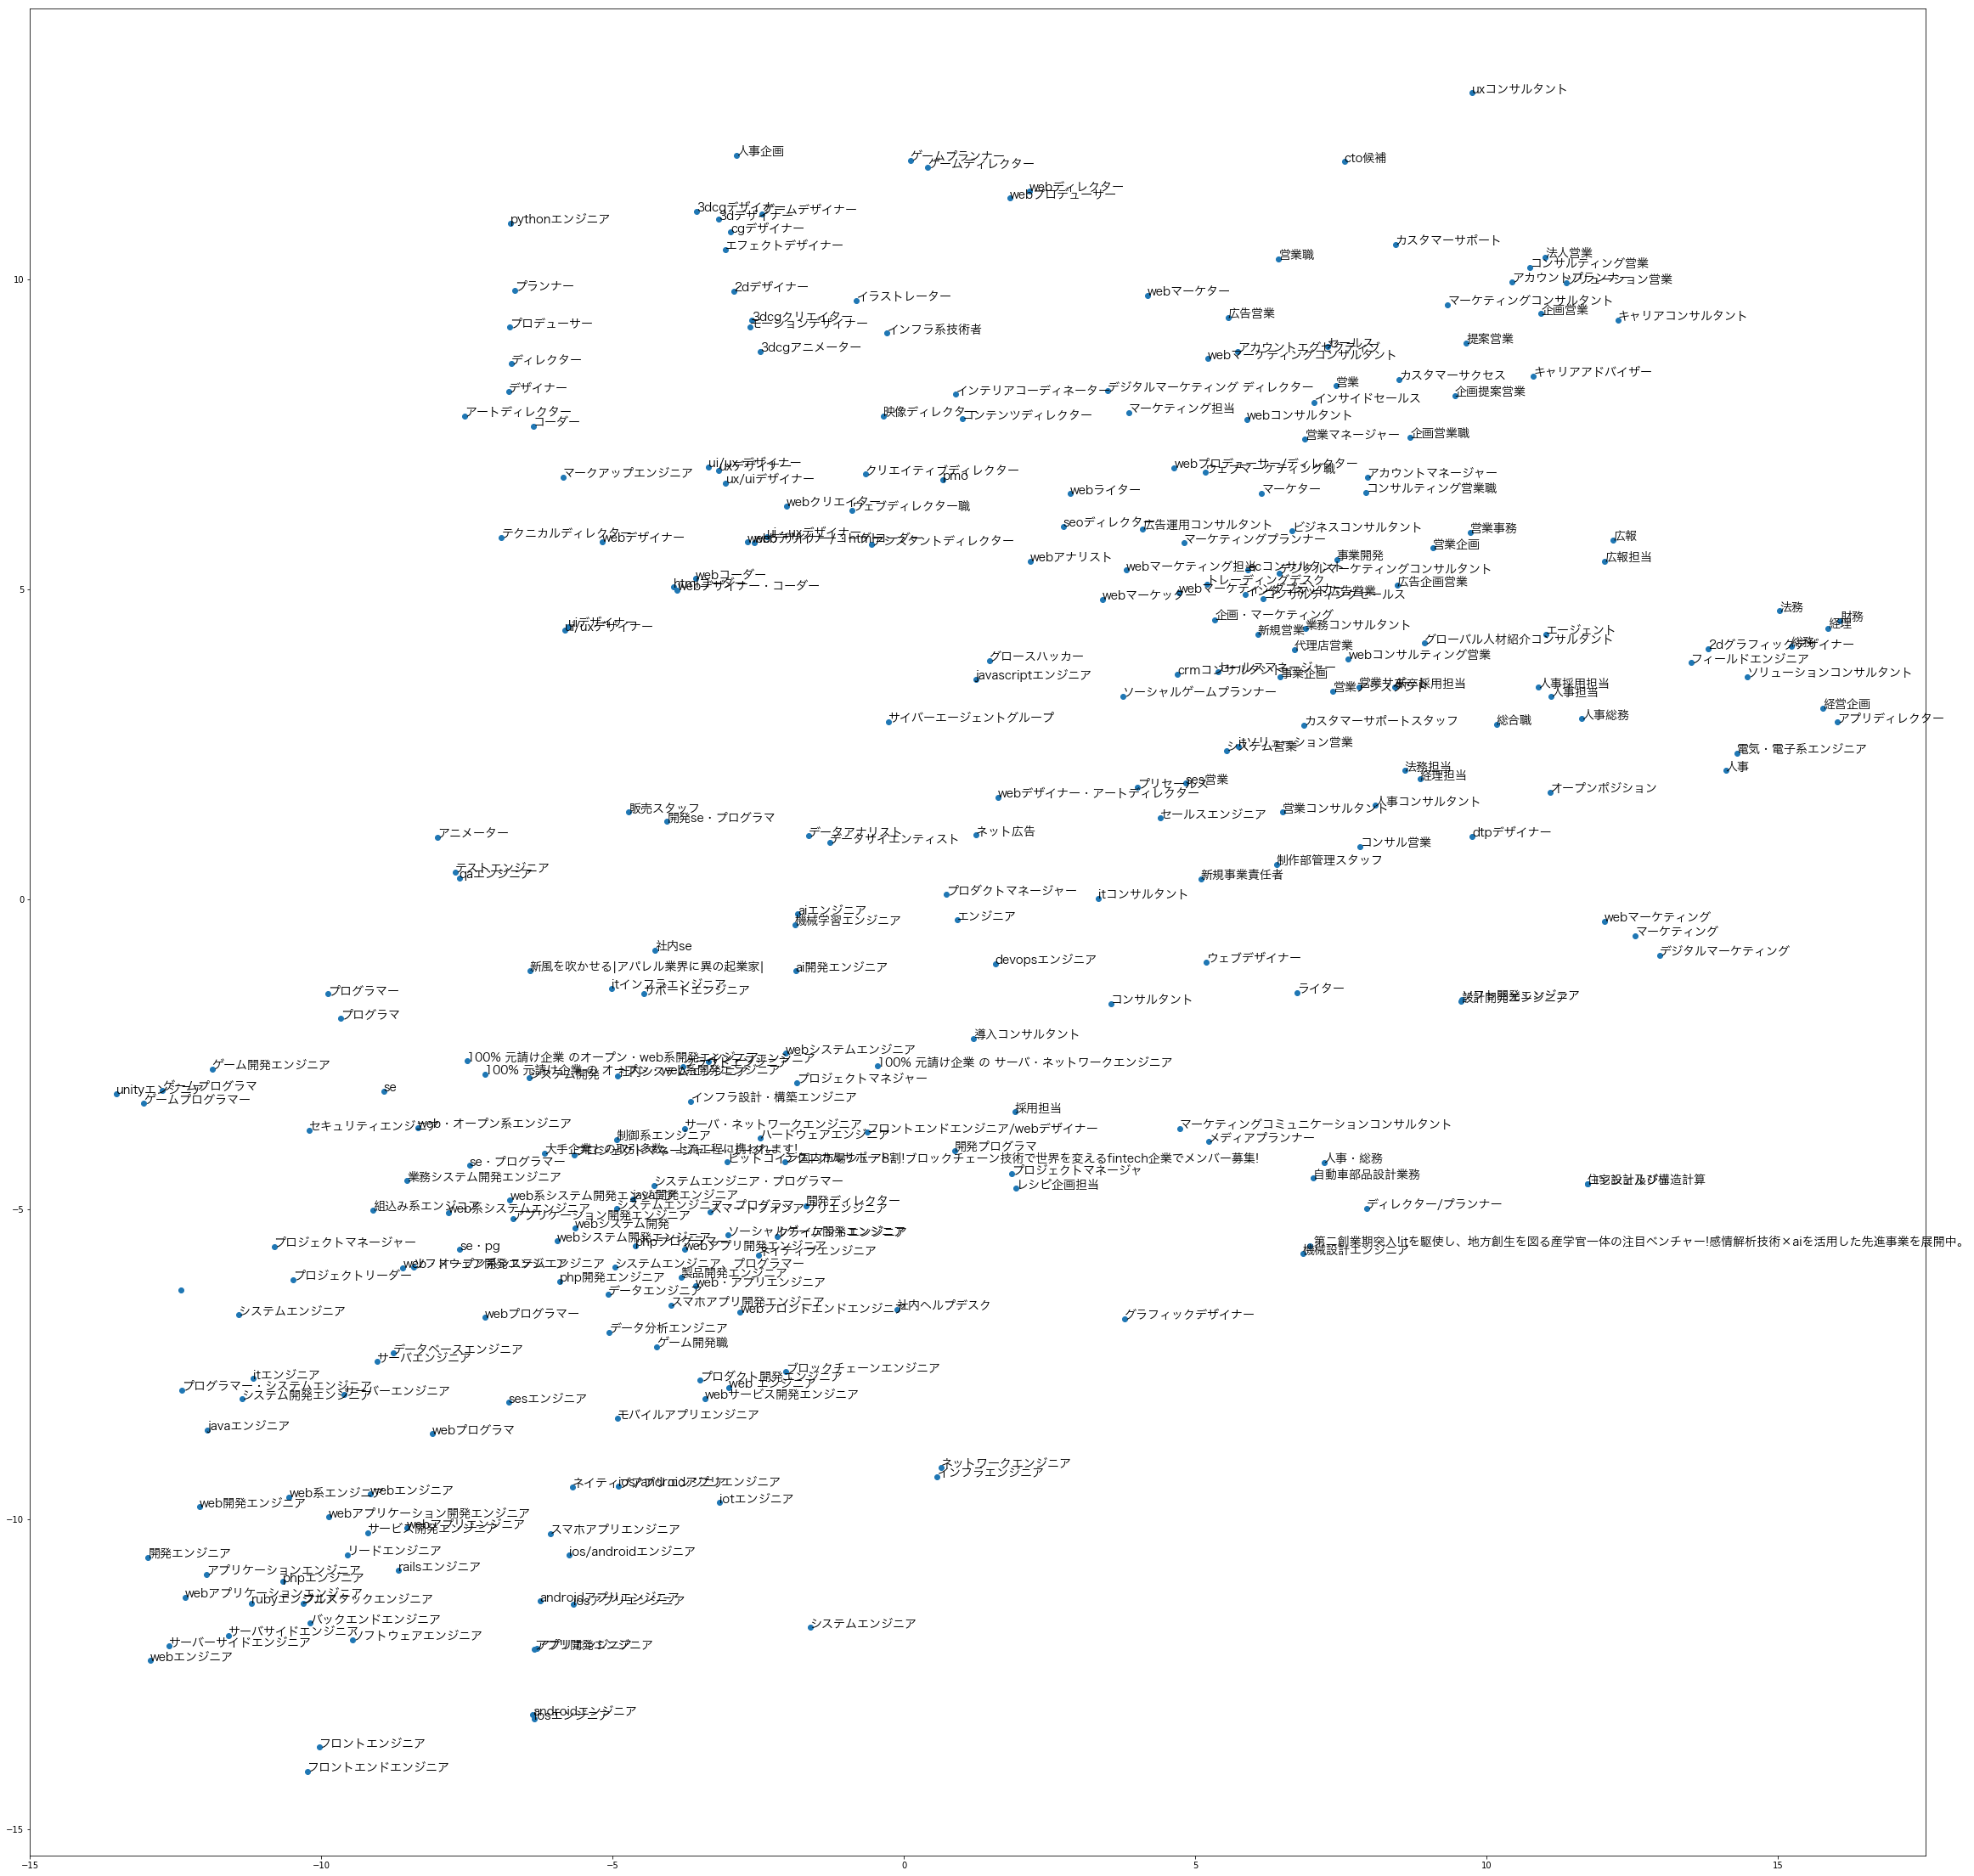

In [16]:
popular_job_titles = job_postings['job_title'].map(normalize_job_title).value_counts()[0:1000].keys()
emb_tuple = tuple([word2vec_model[t] for t in popular_job_titles if t in word2vec_model] )
X = np.vstack(emb_tuple)

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
model.fit_transform(X) 

#matplotlibでt-SNEの図を描く
plt.figure(figsize=(40,40))#図のサイズ
plt.scatter(model.embedding_[:, 0], model.embedding_[:, 1])

for label, x, y in zip(popular_job_titles, model.embedding_[:, 0], model.embedding_[:, 1]):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', fontproperties=fp)
    
plt.show()

# Future work
TODO: add potential applications

# Reading
Here are some resources which you can learn more about word2vec after workshop.
- [Word2vec explanation in DL4j document](https://deeplearning4j.org/word2vec)
- [Gensim documentation](https://radimrehurek.com/gensim/models/word2vec.html)
- [Gensim word2vec tutorial](https://rare-technologies.com/word2vec-tutorial/)
- [Tensorflow tutorial](https://www.tensorflow.org/tutorials/word2vec)
- [Udacity material](https://github.com/udacity/deep-learning/blob/master/embeddings/Skip-Gram_word2vec.ipynb)
- [Conceptual overview](http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/)